# Sovereignty as a Strategic Game (Ultra-CFO)
## Dynamic Programming policy + risk aversion (CVaR) + ambiguity aversion (Wasserstein-DRO)

### Important Context

**This is a first draft toy example for illustrative purposes.** It is not a complete production model but rather a framework for strategic decision analysis. The goal is to demonstrate how to think about supplier dependency as a sequential decision problem under uncertainty.

**Key Assumptions:**
- **Abstract units:** All costs and values are intentionally generic to maintain generalizability. In practice, multiply by your actual cost base.
- **Time periods = years:** Each period $t$ represents one year of operation.
- **Exit timeline:** `exit_years=3` means it takes **3 years from the decision to start migration** until complete exit is achieved (when the firm can terminate the supplier relationship).
- **Simplified dynamics:** Real-world political risk, tariff regimes, and supply chain migration are far more complex than modeled here.

This notebook is a **board/CFO-ready toy model** of supplier dependency framed as a **strategic sequential game**:
- **The firm** chooses actions (wait / invest / hedge / accelerate / exercise exit)
- **Nature** represents political/regulatory dynamics (tariff regime) and, under ambiguity, can choose **adversarial next-state probabilities** within a **Wasserstein ball** of radius $\varepsilon(t)$

The point is not only “how expensive is sovereignty?” but **what policy** is optimal — i.e. **trigger conditions** for investing, hedging, accelerating migration, and exiting.

### Complexity ladder (useful mental model)

- **Level 0 — Expected value (EV)**: trust the nominal transition model, minimize expected discounted cost.
- **Level 1 — CVaR**: same nominal transitions, but optimize **tail risk** (risk aversion).
- **Level 2 — Robust CVaR (Wasserstein-DRO)**: optimize tail risk **and** protect against **model error / misspecification** in transitions (ambiguity aversion).

**Units:** all numbers are in **abstract units**.

Outputs:
- EV vs CVaR vs Robust-CVaR policy/value comparisons
- Baseline vs $\varepsilon(t)$ scenario and **sovereignty premium** (price of ambiguity)
- Diagnostics: tariff=1 start state, policy maps, break-even sanity bounds
- Sensitivity: horizon and tariff persistence
- Slide-like plots

### Reading Guide

**For CFOs and Business Leaders:**
- Start here for context
- Jump to **Section 9** for main results and interpretation
- Review **Section 11** (CFO Interpretation) for business implications
- Scroll to **Executive Summary** at the end for AI-generated synthesis

**For Technical Teams and Risk Managers:**
- Read **Sections 1-8** for full methodology
- Focus on **Section 7** (Dynamic Programming formulation)
- Review **Section 10** for sensitivity analysis

**For Board Members:**
- Read the disclaimer and context above
- Skip to **Section 12** (visualizations) for charts
- Read **Executive Summary** at the end
- Ask CFO to present Section 11 implications

## Glossary of Key Terms

Before diving into the technical details, here are the key concepts in plain business language:

**Core Concepts:**
- **CVaR (Conditional Value-at-Risk):** The average of the worst X% of outcomes (tail risk). Example: CVaR at 90% means "average of the worst 10% of scenarios." CFOs use this to protect against downside.
- **Wasserstein DRO (Distributionally Robust Optimization):** Protection against forecast errors. Instead of trusting one forecast, optimize against a range of plausible forecasts within a "ball" of uncertainty.
- **Epsilon ($\varepsilon$):** How much we distrust our predictions. Larger $\varepsilon$ = more ambiguity = wider range of scenarios we protect against.
- **Sovereignty premium:** The cost of political/regulatory uncertainty. How much more expensive the worst-case becomes when you account for forecast errors.

**Model Elements:**
- **Abstract units:** Intentionally generic numbers. Multiply by your actual cost base to get real values.
- **State:** The current situation (tariff on/off, migration progress, programs started). Think of it as "where we are now."
- **Action:** What you can do (wait, invest, hedge, accelerate, exit). Think of it as "what we decide."
- **Policy:** A rulebook that says "if you're in state X, take action Y." This is the output of the model.
- **Value function $V$:** Worst-case cost-to-go from a state following the optimal policy. Lower is better.

**Time and Money:**
- **Horizon:** How many years ahead we're planning (10 years in the base case).
- **WACC (Weighted Average Cost of Capital):** Discount rate for NPV calculations (10% in the base case).
- **CAPEX:** One-time investments (e.g., setting up new supplier relationships).
- **OPEX:** Recurring costs (e.g., running dual suppliers during migration).

**Risk Language:**
- **Nominal transitions:** Our baseline forecast for how tariffs evolve over time.
- **Ambiguity:** Uncertainty about the forecast itself (not just random outcomes).
- **Tail risk:** Focus on worst outcomes, not averages. Critical for risk-averse CFOs.

In [22]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
from pydantic import BaseModel, Field, field_validator, ConfigDict

np.set_printoptions(precision=3, suppress=True)

ACTION_NAMES = [
    "wait (do nothing)",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]

## 1) Model spec (a strategic game)

### Why this framing matters for CFOs

Traditional supplier dependency analysis often reduces to a single NPV calculation: \"How much does sovereignty cost?\" This misses the **strategic optionality** inherent in the problem. In reality:

- **You can wait** for more information (tariff regime clarity, technology maturity)
- **You can hedge** incrementally (dual suppliers, contract protections)
- **You can accelerate** if the political risk environment deteriorates
- **You have trigger conditions** that adapt to the state of the world

This model captures these real business decisions as **actions in a sequential game**. The output is not just a cost number, but an **actionable policy**: given your current state (tariff regime, migration progress), what should you do?

**Connection to real business:** Think of `wait` as business-as-usual, `invest` as launching a supplier diversification program, `hedge` as setting up alternative suppliers or contracts, `accelerate` as fast-tracking migration (higher OPEX), and `exercise exit` as fully terminating the at-risk supplier once ready.

This toy model simplifies reality but captures the key trade-offs between **near-term costs, long-term risk exposure, and strategic flexibility**.

### Technical specification

We model sovereignty as a **finite-horizon sequential game** between:
- **Firm (min player):** chooses an action $a_t$ each period.
- **Nature (max player):** controls the external environment (tariff regime) and, under ambiguity, can select adversarial next-state probabilities.

**State variables** (Markov):
- tariff regime: $\mathrm{tariff} \in \{0,1\}$
- migration progress: $m \in \{0,\ldots,3\}$ (exit requires $m=3$)
- flags: `inv` (investment program started), `hed` (hedge setup)
- exit exercised: `ex`

**Actions** (macro decisions): wait, invest, hedge-only, accelerate migration, invest+hedge+exercise-if-ready.

**Objective**: compute an **optimal policy** that minimizes discounted cost under three “attitudes” toward uncertainty:
- **EV** (expected cost under nominal transitions)
- **CVaR** (tail-risk aversion under nominal transitions)
- **Robust CVaR** (tail risk **and** ambiguity on transitions via a Wasserstein ball)

This keeps the model DP-solvable while emphasizing the central deliverable: a **policy (trigger rules)**, not just a single cost number.

In [23]:
PlayerId = int
Action = int
State = int

# Action indices (keep explicit; policy arrays store these ints)
WAIT = 0
INVEST = 1
HEDGE_ONLY = 2
ACCELERATE_MIGRATION = 3
INVEST_HEDGE_EXERCISE = 4

class CFOConfig(BaseModel):
    wacc: float = Field(default=0.10, ge=0.0, le=0.5)          # discount rate
    amort_years: int = Field(default=5, ge=1, le=15)           # for reporting (toy)
    tax_rate: float = Field(default=0.25, ge=0.0, le=0.6)      # optional
    objective: str = Field(default="cash_npv", pattern="^(cash_npv|ebitda_npv)$")

class GameSpec(BaseModel):
    # horizon / actions
    horizon: int = 10
    exit_years: int = 3
    actions_per_player: int = 5  # 0=wait, 1=invest, 2=hedge_only, 3=accelerate_migration, 4=invest+hedge/exercise-if-ready

    # risk
    alpha_cvar: float = 0.9

    # tariff / dependency
    tariff_cost: float = 10.0
    hedged_tariff_cost: float = 6.0
    post_exit_cost: float = 0.0  # Zero tariff cost after complete exit

    # Nominal tariff Markov chain (parameterized for sensitivity)
    tariff_p01: float = 0.15  # P(tariff:0->1)
    tariff_p10: float = 0.10  # P(tariff:1->0)

    # CAPEX cash one-off
    capex_invest: float = 8.0
    capex_hedge_setup: float = 2.0

    # OPEX cash recurring
    opex_migration: float = 1.5
    opex_dual_run: float = 0.7

    # Accelerated migration
    accelerate_step: int = 2                 # m += 2 when accelerating
    opex_accelerate_extra: float = 1.5       # extra OPEX per period when accelerating (in addition to opex_migration)

    # exercise costs (cash one-off)
    termination_fee: float = 12.0
    cutover_cost: float = 5.0
    recert_audit_cost: float = 2.0

    # Exogenous learning curve on switching cost (NOT driven by firm effort)
    # Multiplier m(t) = floor + (1-floor)*exp(-kappa*t). Defaults imply no decay.
    exit_cost_floor_mult: float = Field(default=1.0, ge=0.0, le=1.0)
    exit_cost_half_life_years: float = Field(default=0.0, ge=0.0)

    cfo: CFOConfig = CFOConfig()

    @field_validator("exit_cost_half_life_years")
    @classmethod
    def _validate_half_life(cls, v: float):
        # 0.0 means "no learning".
        if v < 0:
            raise ValueError("exit_cost_half_life_years must be >= 0")
        return v

# (JointAction removed: this notebook models a single decision-maker vs. Nature.)

## 2) State encoding

State dimensions:
- $\mathrm{tariff} \in \{0,1\}$
- migration progress: $m \in \{0,\ldots,3\}$
- flags: $\mathrm{inv},\mathrm{hed},\mathrm{ex} \in \{0,1\}$

Total number of states: $|\mathcal{S}| = 2 \times 4 \times 2 \times 2 \times 2 = 64$.

In [24]:
def encode_state(tariff: int, m: int, inv: int, hed: int, ex: int) -> int:
    return (((tariff * 4 + m) * 2 + inv) * 2 + hed) * 2 + ex


def decode_state(s: int):
    ex = s % 2; s //= 2
    hed = s % 2; s //= 2
    inv = s % 2; s //= 2
    m = s % 4;   s //= 4
    tariff = s
    return tariff, m, inv, hed, ex


N_STATES = 2 * 4 * 2 * 2 * 2  # 64

## 3) Wasserstein transport cost

We model ambiguity via a **Wasserstein ball** around the nominal next-state distribution: distributions $p$ with $W_C(p, p_0) \leq \varepsilon(t)$.

We want ambiguity mainly on **tariff dynamics** (political). We penalize moving probability mass across internal flags $(m, \mathrm{inv}, \mathrm{hed}, \mathrm{ex})$ heavily in $C$ so that Nature primarily perturbs tariff persistence/intensity rather than internal execution state.

In [25]:
def transport_cost_matrix():
    C = np.zeros((N_STATES, N_STATES))
    for i in range(N_STATES):
        ti, mi, invi, hedi, exi = decode_state(i)
        for j in range(N_STATES):
            tj, mj, invj, hedj, exj = decode_state(j)

            c_tar = 1.0 * abs(ti - tj)          # cheap to move across tariff
            c_m   = 10.0 * abs(mi - mj)         # expensive to move across progress
            c_inv = 50.0 * abs(invi - invj)     # very expensive across flags
            c_hed = 50.0 * abs(hedi - hedj)
            c_ex  = 50.0 * abs(exi - exj)

            C[i, j] = c_tar + c_m + c_inv + c_hed + c_ex
    return C

## 4) Nominal transition and time constraint

- **Tariff**: nominal 2-state Markov chain $P(\mathrm{tariff}_{t+1} \mid \mathrm{tariff}_t)$ with $p_{01}$, $p_{10}$.
- **Progress** $m$ increases each period depending on action (e.g. +1 for invest/hedge, +2 for accelerate), capped at $\mathrm{exit\_years}$.
- **Exit** is exercised when the invest+hedge/exercise action is chosen and $m$ has reached $\mathrm{exit\_years}$.

In [26]:
def nominal_tariff_transition(spec: GameSpec, tariff: int) -> np.ndarray:
    # Parameterized nominal dynamics; can be stressed/calibrated.
    p01 = float(spec.tariff_p01)
    p10 = float(spec.tariff_p10)
    if tariff == 0:
        return np.array([1.0 - p01, p01])
    return np.array([p10, 1.0 - p10])


def progress_increment(spec: GameSpec, action: int) -> int:
    if action in (INVEST, INVEST_HEDGE_EXERCISE):
        return 1
    if action == ACCELERATE_MIGRATION:
        return int(spec.accelerate_step)
    return 0


def next_progress(spec: GameSpec, m: int, action: int) -> int:
    inc = progress_increment(spec, action)
    return min(spec.exit_years, m + inc)


def build_p0_over_full_state(spec: GameSpec, s: int, action: int) -> np.ndarray:
    tariff, m, inv, hed, ex = decode_state(s)

    # absorbing after exit
    if ex == 1:
        m_next, inv_next, hed_next, ex_next = spec.exit_years, inv, hed, 1
    else:
        m_next = next_progress(spec, m, action)

        inv_next = inv or (1 if action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE) else 0)
        hed_next = hed or (1 if action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE) else 0)

        # exercise is only triggered by the invest+hedge/exercise action once progress is complete
        ex_next = 1 if (action == INVEST_HEDGE_EXERCISE and m_next == spec.exit_years) else 0

    p_tar = nominal_tariff_transition(spec, tariff)
    p0 = np.zeros(N_STATES)

    for tariff_next in (0, 1):
        s_next = encode_state(tariff_next, m_next, int(inv_next), int(hed_next), int(ex_next))
        p0[s_next] += p_tar[tariff_next]

    return p0

## 5) Cash vs EBITDA mapping (CFO)

### Why both metrics matter

CFOs track both cash and EBITDA for different stakeholders:
- **Cash** matters for **treasury and liquidity management**: Can we afford the CAPEX? Do we have the cash flow?
- **EBITDA** matters for **investors and valuation**: What's the ongoing operational impact on earnings?

In this model:
- **One-off costs** (CAPEX, exit termination fees) hit cash immediately but don't affect steady-state EBITDA
- **Recurring costs** (OPEX, tariffs) impact both cash and EBITDA
- The **policy that optimizes cash NPV** may differ from the one that optimizes EBITDA impact

For a board presentation, you might emphasize EBITDA (P&L impact). For a credit committee, emphasize cash (liquidity impact). This notebook supports both.

### Technical details

We compute per-period impacts:
- **Total cost (cash)** = CAPEX + OPEX + tariff cost + exercise cost (one-off).
- **Exercise (switching) cost**: one-off cost to exit (termination + cutover + recert).
- **EBITDA proxy (toy)**: OPEX + tariff (exercise treated as exceptional).

Objective (discounted at WACC $r$):
- `cash_npv`: worst-case CVaR of $\sum_t \gamma_t \cdot \mathrm{total\_cost}_t$ with $\gamma_t = (1+r)^{-t}$.
- `ebitda_npv`: same on the EBITDA proxy.

Note: **lower is better** (we minimize risk-adjusted total cost).

In [27]:
def discount_factor(spec: GameSpec, t: int) -> float:
    r = spec.cfo.wacc
    return 1.0 / ((1.0 + r) ** t)


def base_exit_cost(spec: GameSpec) -> float:
    """One-off exit cost at t=0 (termination + cutover + recert)."""
    return spec.termination_fee + spec.cutover_cost + spec.recert_audit_cost


def exit_cost_multiplier(spec: GameSpec, t: int) -> float:
    """Exogenous learning curve multiplier on exit cost.

    m(t) = floor + (1-floor) * exp(-kappa*t)
    where kappa = ln(2)/half_life.

    half_life=0 => no learning (m(t)=1).
    """
    floor = float(spec.exit_cost_floor_mult)
    hl = float(spec.exit_cost_half_life_years)
    if hl <= 0:
        return 1.0

    kappa = np.log(2.0) / hl
    return float(floor + (1.0 - floor) * np.exp(-kappa * float(t)))


def exit_cost_at_t(spec: GameSpec, t: int) -> float:
    return float(base_exit_cost(spec) * exit_cost_multiplier(spec, t))


def hedge_effectiveness_factor(spec: GameSpec, m: int, hed: int, action: int) -> float:
    """Returns hedge effectiveness [0,1] based on migration progress.
    
    Hedge only works if setup (hed=1 or current action sets it up).
    Effectiveness scales linearly with migration progress:
    - m=0: 0% effective (no migration yet)
    - m=1: 33% effective (1/3 migrated)
    - m=2: 67% effective (2/3 migrated)
    - m=3: 100% effective (fully migrated)
    
    Business logic: As you migrate more of your operations, the hedge
    (alternative suppliers, contract protections) becomes more effective
    at reducing tariff exposure.
    """
    hed_setup = (hed == 1) or (action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE))
    if not hed_setup:
        return 0.0
    if spec.exit_years == 0:
        return 1.0  # edge case
    return float(m) / float(spec.exit_years)


def stage_losses_cfo(spec: GameSpec, t: int, s: int, action: int):
    tariff, m, inv, hed, ex = decode_state(s)

    # CAPEX cash one-off
    capex_cash = 0.0
    if inv == 0 and action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE):
        capex_cash += spec.capex_invest
    if hed == 0 and action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE):
        capex_cash += spec.capex_hedge_setup

    # OPEX recurring while migrating and investment started
    invest_started = (inv == 1) or (action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE))
    opex_cash = 0.0
    if ex == 0 and invest_started and m < spec.exit_years:
        opex_cash += spec.opex_migration
        if action == ACCELERATE_MIGRATION:
            opex_cash += spec.opex_accelerate_extra
        if tariff == 1:
            opex_cash += spec.opex_dual_run

    # Exercise costs
    exercise_cash = 0.0
    m_next = next_progress(spec, m, action)
    will_exercise = (ex == 0 and action == INVEST_HEDGE_EXERCISE and m_next == spec.exit_years)
    if will_exercise:
        exercise_cash += exit_cost_at_t(spec, t)

    # Tariff cash cost (with progressive hedge effectiveness)
    tariff_cash = 0.0
    if tariff == 1:
        if ex == 1:
            tariff_cash = spec.post_exit_cost
        else:
            # Progressive hedge: effectiveness scales with migration progress
            hedge_factor = hedge_effectiveness_factor(spec, m, hed, action)
            tariff_cash = (1 - hedge_factor) * spec.tariff_cost + hedge_factor * spec.hedged_tariff_cost

    cash = capex_cash + opex_cash + exercise_cash + tariff_cash

    # EBITDA proxy: OPEX + tariff (exercise excluded)
    ebitda = opex_cash + tariff_cash
    ebit = ebitda  # kept for compatibility (toy)

    return cash, ebitda, ebit

## 6) Level 2 — Robust CVaR under Wasserstein ambiguity (LP)

This is the **ambiguity-averse** layer: we do not fully trust the nominal next-state model $p_0(\cdot\mid s,a)$, so we allow **Nature** to choose an adversarial distribution $p$ inside a Wasserstein ball.

- $\alpha$ controls **tail risk aversion** (CVaR).
- $\varepsilon$ controls **ambiguity aversion** (how much Nature can distort $p_0$).
- $C$ (transport cost) encodes what kinds of distribution shifts are “cheap” for Nature.

We solve the **robust CVaR** problem:

$$
\sup_{p \,:\, W_C(p, p_0) \leq \varepsilon} \;\mathrm{CVaR}_\alpha^p(L)
= \inf_{\eta,\lambda\geq 0,\,u} \left\{ \eta + \lambda \varepsilon + p_0^\top u \right\}
$$

subject to the dual constraints of the Wasserstein ball and the CVaR reformulation ($L$ = loss vector, $\alpha$ = tail level). Implemented as a **convex LP** (DCP).

In [28]:
class RiskConfig(BaseModel):
    alpha: float = Field(..., gt=0, lt=1)
    wasserstein_eps: float = Field(..., ge=0)


class TransportCost(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    C: np.ndarray


class RobustCVaRWasserstein:
    def __init__(self, cfg: RiskConfig, cost: TransportCost):
        self.cfg = cfg
        self.C = cost.C

    def evaluate(self, p0: np.ndarray, losses: np.ndarray) -> float:
        """
        DCP-safe LP reformulation of:
            sup_{p: W_C(p,p0) <= eps} CVaR_alpha^p(losses)
        using duality (Esfahani & Kuhn-style).
        """
        n = len(losses)
        alpha = float(self.cfg.alpha)
        eps = float(self.cfg.wasserstein_eps)

        # Decision variables (all DCP-friendly)
        eta = cp.Variable()                 # VaR threshold
        t = cp.Variable(n, nonneg=True)     # t_j >= (loss_j - eta)_+
        lam = cp.Variable(nonneg=True)      # Wasserstein dual multiplier
        u = cp.Variable(n)                  # dual potentials

        constraints = []
        constraints += [t >= losses - eta]

        # Dual constraints for Wasserstein support function:
        scale = 1.0 / (1.0 - alpha)
        for j in range(n):
            constraints += [u + lam * self.C[:, j] >= scale * t[j]]

        objective = cp.Minimize(eta + lam * eps + p0 @ u)
        problem = cp.Problem(objective, constraints)

        try:
            problem.solve(solver=cp.CLARABEL, verbose=False)
        except cp.error.SolverError:
            problem.solve(solver=cp.SCS, eps=1e-8, max_iters=25000, verbose=False)

        if problem.status not in ("optimal", "optimal_inaccurate"):
            raise RuntimeError(f"Robust CVaR LP failed: {problem.status}")

        return float(problem.value)


## 7) DP solver (the game) + time-varying $\varepsilon(t)$

**Backward induction** (finite horizon $T$) solves a min–max game: the firm chooses actions and **Nature** chooses the environment (and, under ambiguity, the worst-case transition law).

We compute three variants to show the complexity ladder (EV → CVaR → Robust CVaR).

$$
V(t,s) = \min_{a} \; \sup_{p \,:\, W_C(p,p_0)\leq \varepsilon(t)} \mathrm{CVaR}_\alpha^p\bigl( \gamma_t \cdot \ell(t,s,a) + V(t+1, S') \bigr)
$$

with $\ell$ = stage cash/EBITDA impact and $p_0 = p_0(\cdot \mid s, a)$ the nominal next-state distribution. We compute the **value function** $V$ and **policy** $\pi(t,s)$ (optimal action).

The equation shown corresponds to **Level 2 (Robust CVaR)**. For Levels 0–1, replace the robust operator as:
- **EV (Level 0):** $\mathbb{E}_{p_0}[\cdot]$
- **CVaR (Level 1):** $\mathrm{CVaR}_{\alpha}^{p_0}(\cdot)$


In [29]:
def cvar_discrete_worst_tail(p0: np.ndarray, losses: np.ndarray, alpha: float) -> float:
    """Fast CVaR_alpha(loss) for a discrete distribution p0.

    Returns average of the worst (1-alpha) tail.
    """
    p0 = np.asarray(p0, dtype=float)
    losses = np.asarray(losses, dtype=float)

    tail_mass = 1.0 - float(alpha)
    if tail_mass <= 0:
        return float(losses.max())

    # sort by loss descending (worst first)
    idx = np.argsort(-losses)
    p = p0[idx]
    l = losses[idx]

    acc = 0.0
    tail_loss = 0.0
    for pj, lj in zip(p, l):
        if pj <= 0:
            continue
        take = min(pj, tail_mass - acc)
        if take > 0:
            tail_loss += take * lj
            acc += take
        if acc >= tail_mass - 1e-12:
            break

    # if tail mass is not fully covered (numerical), fall back to expected loss
    if acc <= 0:
        return float(np.dot(p0, losses))

    return float(tail_loss / acc)


def dp_solve_cfo(spec: GameSpec, C: np.ndarray, eps_fn, log_lp_timing=True):
    A = spec.actions_per_player
    p = spec.horizon

    V = np.zeros((p + 1, N_STATES))
    pi = np.zeros((p, N_STATES), dtype=int)

    total_steps = p * N_STATES
    pbar = tqdm(total=total_steps, desc="DP (t, s)", unit="state")

    lp_times = []  # optional diagnostics

    for t in reversed(range(p)):
        eps_t = float(eps_fn(t, p))
        alpha = float(spec.alpha_cvar)

        risk_eval = None
        if eps_t > 0:
            risk_eval = RobustCVaRWasserstein(
                RiskConfig(alpha=alpha, wasserstein_eps=eps_t),
                TransportCost(C=C)
            )

        disc = discount_factor(spec, t)

        for s in range(N_STATES):
            vals = []

            for a in range(A):
                p0 = build_p0_over_full_state(spec, s, a)

                cash, ebitda, _ = stage_losses_cfo(spec, t, s, a)
                flow = cash if spec.cfo.objective == "cash_npv" else ebitda
                losses = disc * flow + V[t + 1, :]

                if eps_t <= 0:
                    val = cvar_discrete_worst_tail(p0, losses, alpha)
                else:
                    t0 = time.time()
                    val = risk_eval.evaluate(p0, losses)
                    if log_lp_timing:
                        lp_times.append(time.time() - t0)

                vals.append(val)

            vals = np.asarray(vals)
            best = int(vals.argmin())
            pi[t, s] = best
            V[t, s] = vals[best]

            pbar.update(1)

    pbar.close()

    if log_lp_timing and len(lp_times) > 0:
        lp_times = np.asarray(lp_times)
        print(
            f"[LP timing] mean={lp_times.mean():.3f}s | "
            f"p90={np.percentile(lp_times,90):.3f}s | "
            f"p99={np.percentile(lp_times,99):.3f}s | "
            f"est total={(lp_times.mean()*p*A*N_STATES):.1f}s"
        )

    return V, pi

## 8) $\varepsilon(t)$ from a risk indicator

### Business interpretation: How much do we distrust our forecasts?

$\varepsilon(t)$ represents **how much we distrust our political risk forecasts** at time $t$. A larger $\varepsilon$ means more ambiguity: Nature (the adversarial environment) can shift the tariff transition probabilities further from our baseline assumptions.

**In practice, link this to observable indicators:**
- **Policy uncertainty indices** (e.g., Economic Policy Uncertainty Index)
- **Election cycles** (higher ambiguity in election years)
- **Trade tensions** (WTO disputes, bilateral negotiations)
- **Geopolitical risk scores**

For example, if a major election is coming in year 2, set $\varepsilon(2)$ high. If a trade agreement is being renegotiated in years 1-3, keep $\varepsilon$ elevated during that window.

This toy example uses a simple cyclical pattern, but a real implementation would calibrate $\varepsilon(t)$ to your specific risk environment.

### Technical approach

We use a CFO-friendly approach:
- **Risk indicator** $R(t) \in [0,1]$ (e.g. cyclical or macro-driven).
- **Ambiguity radius** $\varepsilon(t) = \varepsilon_{\min} + (\varepsilon_{\max} - \varepsilon_{\min}) \cdot R(t)$ so $\varepsilon(t) \in [\varepsilon_{\min}, \varepsilon_{\max}]$.

In [30]:
def risk_indicator(t, horizon):
    # toy: cycle (0 -> 1 -> 0)
    x = t / max(1, horizon-1)
    return float(4*x*(1-x))

def eps_from_risk(R, eps_min=0.02, eps_max=0.30):
    return eps_min + (eps_max - eps_min) * R

def eps_schedule_indicator(t, horizon):
    return eps_from_risk(risk_indicator(t, horizon))

# More volatile environment: larger Wasserstein ball (eps_max=0.4)
def eps_schedule_volatile(t, horizon, eps_max=0.40):
    return eps_from_risk(risk_indicator(t, horizon), eps_max=eps_max)


# Macro evaluations: twisted risk/ambiguity
# - Risk: max at year 1, then slide down
def risk_indicator_macro(t, horizon):
    if t <= 1:
        return 1.0 if t == 1 else 0.8  # swing max to year 1
    decay = 0.9 / max(1, horizon - 2)
    return max(0.05, 1.0 - (t - 1) * decay)


# - Ambiguity: spikes in year 1 and 3, local min at year 2
def eps_schedule_macro(t, horizon, eps_min=0.02, eps_max=0.30):
    if t == 1 or t == 3:
        return eps_max
    if t == 2:
        return eps_min
    if t == 0:
        return eps_min + 0.4 * (eps_max - eps_min)
    return eps_min + 0.3 * (eps_max - eps_min) * max(0, 1.0 - 0.2 * (t - 3))

## 9) Run: EV vs CVaR vs Robust-CVaR + sovereignty premium

### What we're computing

We now compute **optimal policies and their worst-case costs** under three levels of sophistication:

- **EV baseline (Level 0):** Trust your forecast. Optimize expected cost assuming tariff transitions happen exactly as modeled.
- **CVaR baseline (Level 1):** Protect against bad draws. Optimize the worst 10% of outcomes (tail risk) under your forecast.
- **Robust CVaR (Level 2):** Protect against bad draws AND bad forecasts. Optimize tail risk when Nature can adversarially shift probabilities within a $\varepsilon(t)$ ball.

**Why this matters:** A policy that looks optimal under EV might be disastrous if your tariff forecast is wrong. Robust CVaR quantifies how much worse things get when you account for forecast uncertainty.

**Sovereignty premium (price of ambiguity):**
\[
\text{premium} = V_0^{\text{robust}} - V_0^{\text{nominal CVaR}}\,.
\]
Positive means ambiguity makes the worst-case outlook more expensive, even under the optimal policy.

**Interpretation:** Think of the premium as a **stress buffer** for budgeting. If the sovereignty premium is 15% of baseline cost, that's how much worse the optimal worst-case could be when you account for political uncertainty.

### Decision rules from the results

After computing the policies, look for patterns like:
- **If tariff persists AND migration < 2 years → hedge** (immediate protection)
- **If tariff persists AND migration >= 2 years → accelerate** (you're close to exit)
- **If no tariff → wait** (no urgency to act)

The model will show you the specific trigger conditions encoded in the optimal policy.

In [31]:
spec = GameSpec(
    horizon=10,
    cfo=CFOConfig(wacc=0.10, amort_years=5, objective="cash_npv"),
    # tariff_p01=0.15,
    # tariff_p10=0.10,
)

C = transport_cost_matrix()

# Start state: tariff off, no migration, no flags, no exit
s0 = encode_state(tariff=0, m=0, inv=0, hed=0, ex=0)

V_base, pi_base = dp_solve_cfo(spec, C, eps_fn=lambda t, h: 0.0)
V_scn,  pi_scn  = dp_solve_cfo(spec, C, eps_fn=eps_schedule_indicator)
V_vol,  pi_vol  = dp_solve_cfo(spec, C, eps_fn=eps_schedule_volatile)  # volatile: eps_max=0.4
V_macro, pi_macro = dp_solve_cfo(spec, C, eps_fn=eps_schedule_macro)  # macro evaluations

V0_base = V_base[0, s0]
V0_scn  = V_scn[0, s0]
V0_vol  = V_vol[0, s0]
V0_macro = V_macro[0, s0]
premium = V0_scn - V0_base
premium_volatile = V0_vol - V0_base
premium_macro = V0_macro - V0_base

summary = pd.DataFrame([
    {
        "objective": spec.cfo.objective,
        "WACC": spec.cfo.wacc,
        "V0_baseline_eps0": V0_base,
        "V0_eps(t)": V0_scn,
        "V0_volatile_eps_max0.4": V0_vol,
        "V0_macro": V0_macro,
        "sovereignty_premium": premium,
        "premium_volatile": premium_volatile,
        "premium_macro": premium_macro,
        "a0_baseline": int(pi_base[0, s0]),
        "a0_eps(t)": int(pi_scn[0, s0]),
        "a0_volatile": int(pi_vol[0, s0]),
        "a0_macro": int(pi_macro[0, s0]),
    }
])

summary

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

[LP timing] mean=0.060s | p90=0.094s | p99=0.162s | est total=193.1s


DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

[LP timing] mean=0.060s | p90=0.091s | p99=0.175s | est total=191.6s


DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

[LP timing] mean=0.062s | p90=0.094s | p99=0.162s | est total=197.1s


,objective,WACC,V0_baseline_eps0,V0_eps(t),V0_volatile_eps_max0.4,V0_macro,sovereignty_premium,premium_volatile,premium_macro,a0_baseline,a0_eps(t),a0_volatile,a0_macro
0,cash_npv,0.1,38.757576,43.635738,45.187035,42.638536,4.878163,6.429459,3.88096,3,3,3,3


In [32]:
# Diagnostics: tariff=1 start state (m=0, inv=0, hed=0, ex=0)
s0_tariff1 = encode_state(tariff=1, m=0, inv=0, hed=0, ex=0)


def summarize_start_state(s_start: int):
    V0_base_s = float(V_base[0, s_start])
    V0_scn_s = float(V_scn[0, s_start])
    V0_vol_s = float(V_vol[0, s_start])
    V0_macro_s = float(V_macro[0, s_start])

    prem_scn_s = V0_scn_s - V0_base_s
    prem_vol_s = V0_vol_s - V0_base_s
    prem_macro_s = V0_macro_s - V0_base_s

    rows = [
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Baseline (no ambiguity)",
            "a0": int(pi_base[0, s_start]),
            "a0_name": ACTION_NAMES[int(pi_base[0, s_start])],
            "V0": V0_base_s,
            "Cost vs baseline": 0.0,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Standard eps(t)",
            "a0": int(pi_scn[0, s_start]),
            "a0_name": ACTION_NAMES[int(pi_scn[0, s_start])],
            "V0": V0_scn_s,
            "Cost vs baseline": -prem_scn_s,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Volatile eps_max=0.4",
            "a0": int(pi_vol[0, s_start]),
            "a0_name": ACTION_NAMES[int(pi_vol[0, s_start])],
            "V0": V0_vol_s,
            "Cost vs baseline": -prem_vol_s,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Macro evaluations",
            "a0": int(pi_macro[0, s_start]),
            "a0_name": ACTION_NAMES[int(pi_macro[0, s_start])],
            "V0": V0_macro_s,
            "Cost vs baseline": -prem_macro_s,
        },
    ]

    return pd.DataFrame(rows)

_required = ["V_base", "V_scn", "V_vol", "V_macro", "pi_base", "pi_scn", "pi_vol", "pi_macro"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    print("Run Section 9 (DP runs) first; missing:", _missing)
else:
    print("Start state diagnostic: tariff already ON (tariff=1, m=0, inv=0, hed=0, ex=0)")
    start_diag = summarize_start_state(s0_tariff1)
    start_diag


Start state diagnostic: tariff already ON (tariff=1, m=0, inv=0, hed=0, ex=0)


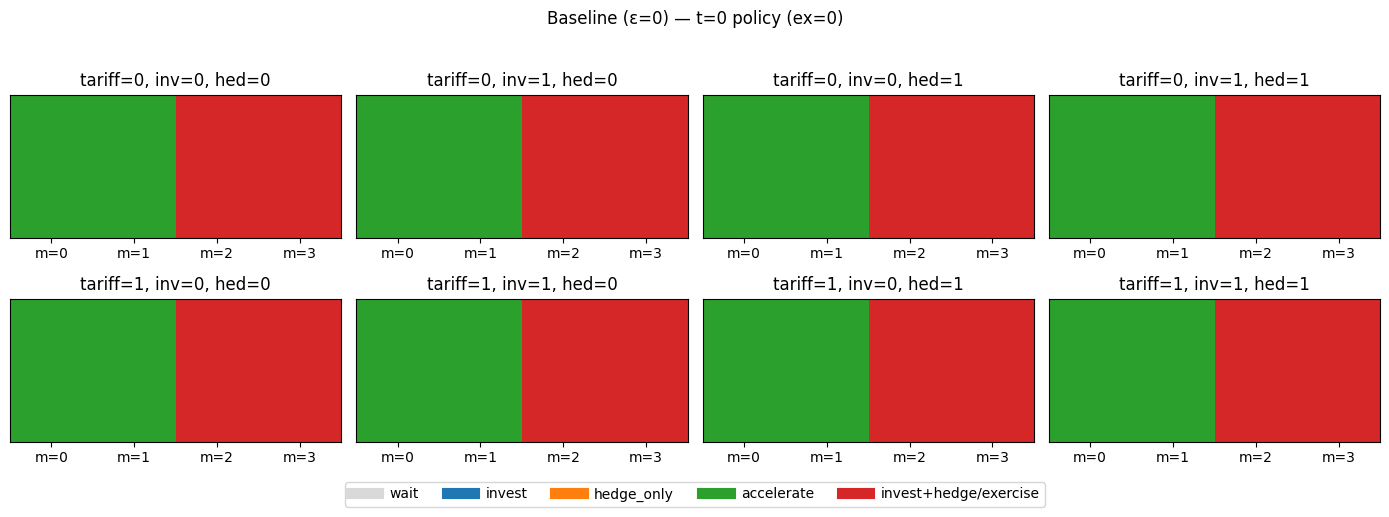

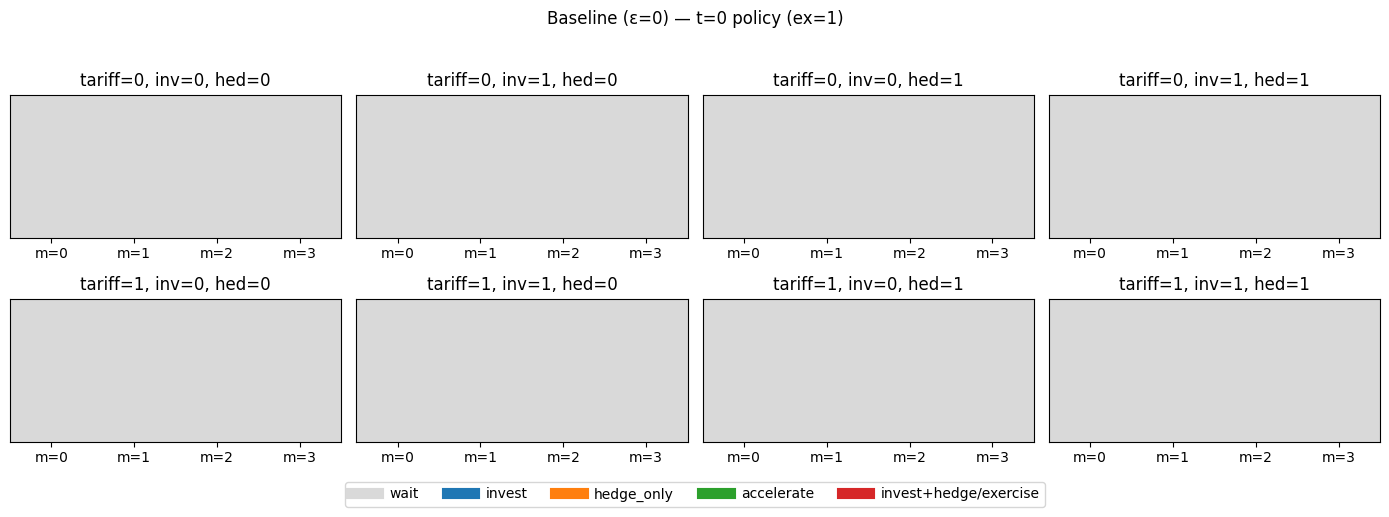

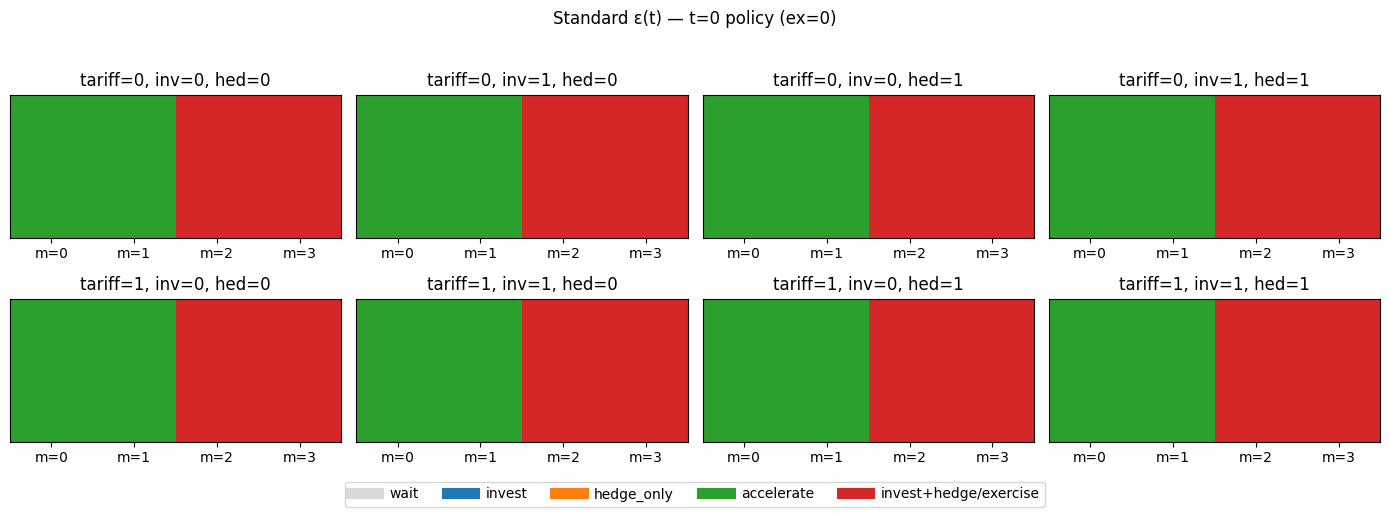

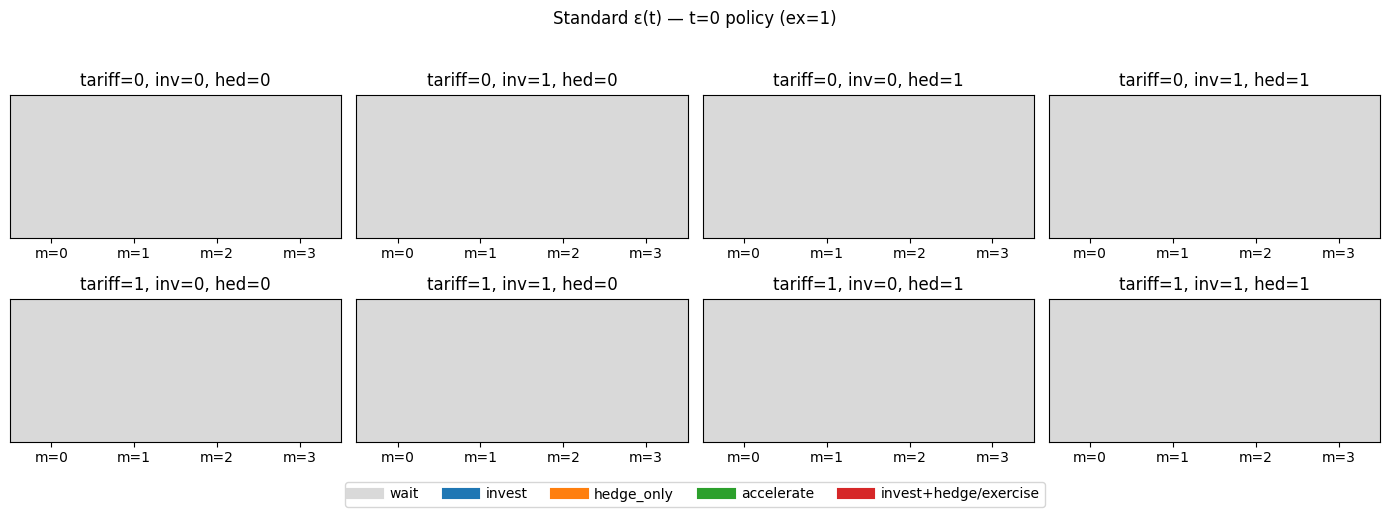

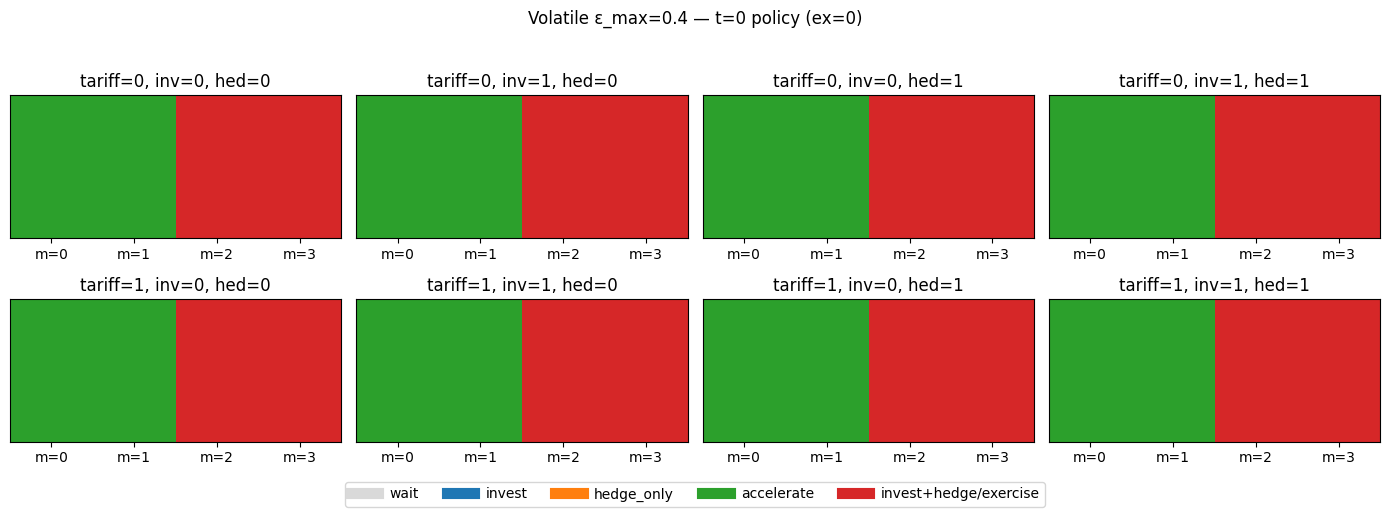

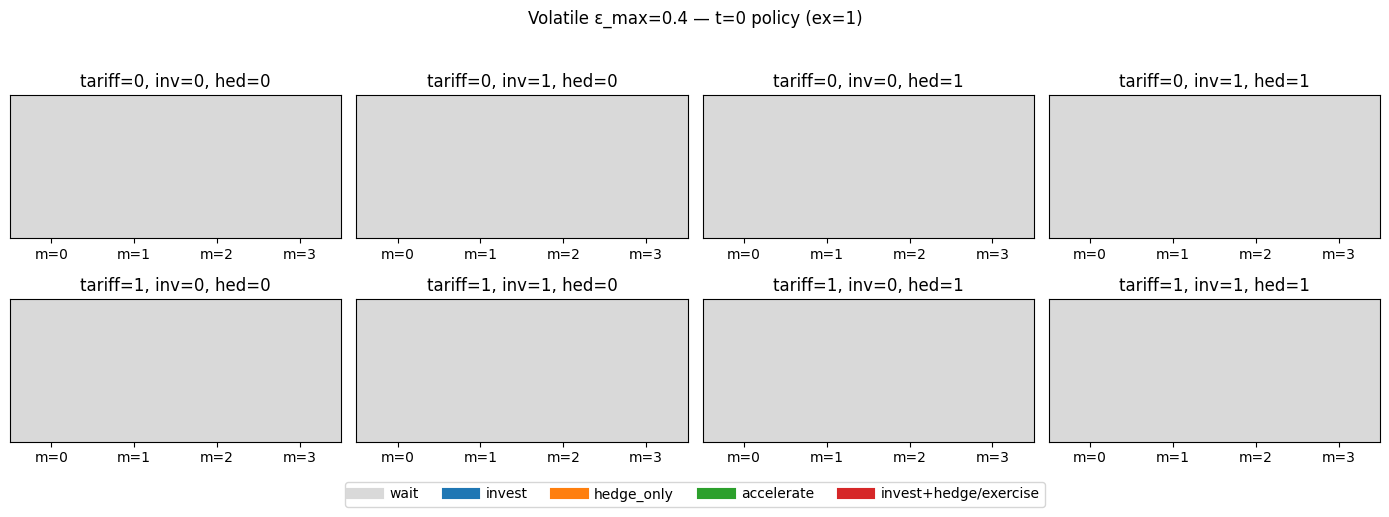

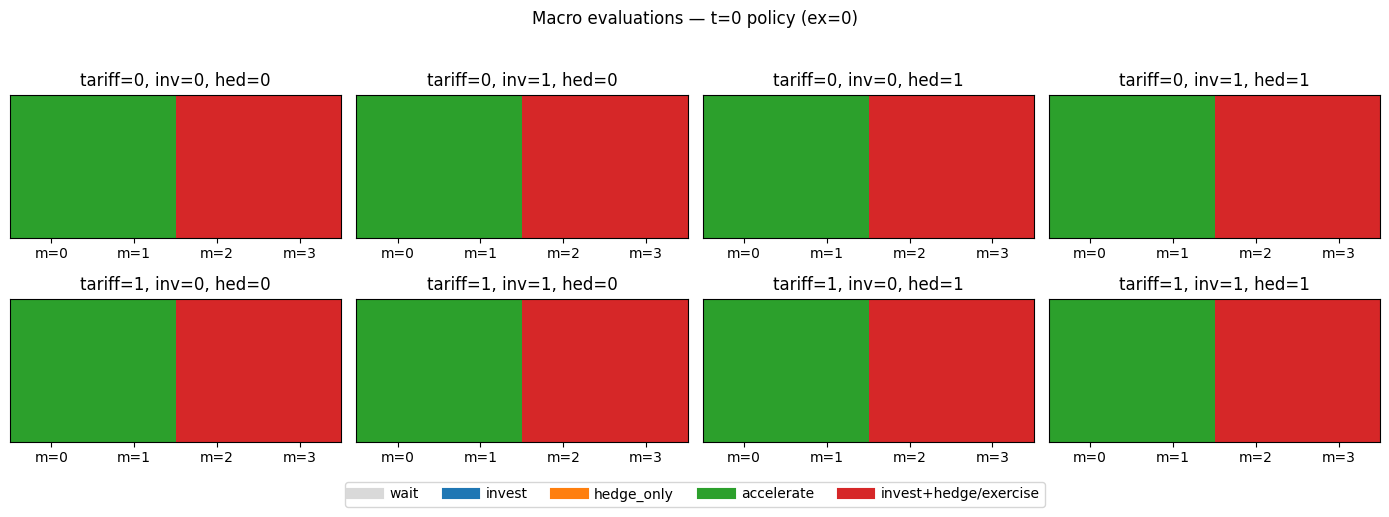

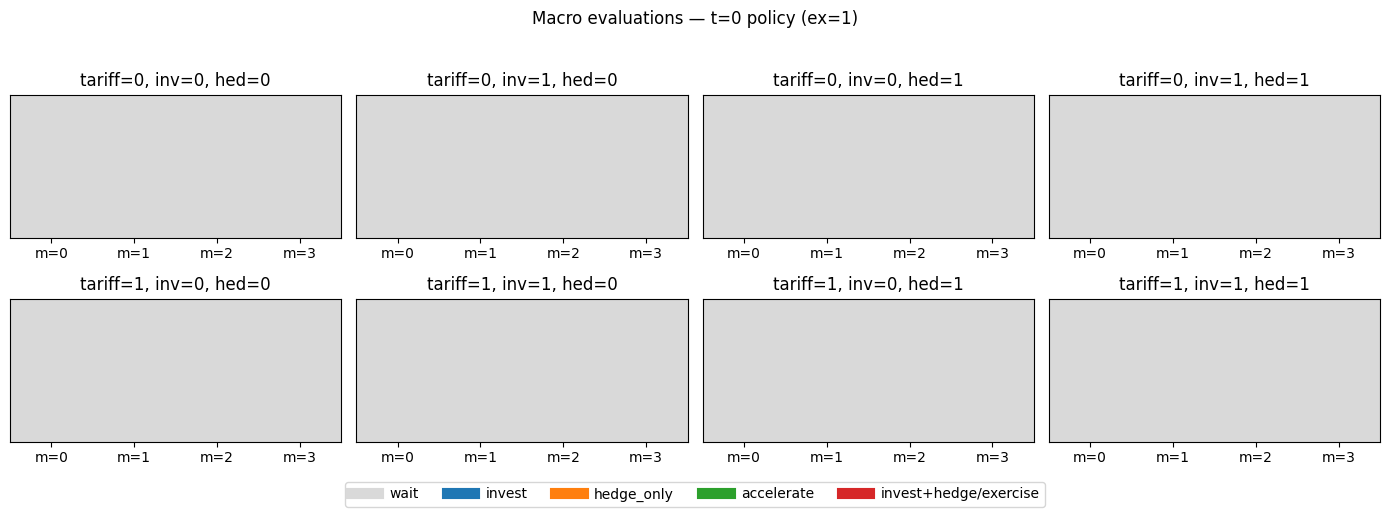

In [33]:
# Diagnostics: policy maps (faceted) at t=0
import matplotlib.colors as mcolors


def policy_df_at_t(pi: np.ndarray, t: int = 0) -> pd.DataFrame:
    rows = []
    for s in range(N_STATES):
        tariff, m, inv, hed, ex = decode_state(s)
        rows.append(
            {
                "s": s,
                "t": t,
                "tariff": tariff,
                "m": m,
                "inv": inv,
                "hed": hed,
                "ex": ex,
                "a": int(pi[t, s]),
                "a_name": ACTION_NAMES[int(pi[t, s])],
            }
        )
    return pd.DataFrame(rows)


def plot_policy_facets(df: pd.DataFrame, title: str):
    # Color map for actions (5 actions)
    cmap = mcolors.ListedColormap(["#d9d9d9", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)

    inv_hed_cols = [(0, 0), (1, 0), (0, 1), (1, 1)]

    for ex_val in (0, 1):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 4.8), sharey=True)
        fig.suptitle(f"{title} — t=0 policy (ex={ex_val})", y=1.03)

        for r, tariff_val in enumerate((0, 1)):
            for c, (inv_val, hed_val) in enumerate(inv_hed_cols):
                ax = axes[r, c]
                sub = df[(df.ex == ex_val) & (df.tariff == tariff_val) & (df.inv == inv_val) & (df.hed == hed_val)]

                a_by_m = np.full((1, 4), np.nan)
                for m_val in range(4):
                    a = sub[sub.m == m_val].a.values
                    if len(a) == 1:
                        a_by_m[0, m_val] = a[0]

                ax.imshow(a_by_m, cmap=cmap, norm=norm, aspect="auto")
                ax.set_xticks(range(4))
                ax.set_xticklabels(["m=0", "m=1", "m=2", "m=3"], rotation=0)
                ax.set_yticks([])

                ax.set_title(f"tariff={tariff_val}, inv={inv_val}, hed={hed_val}")

                # No inline labels (avoids overlap); use legend below.
                # If you want labels back, consider increasing figsize or using interactive hover.

        handles = [
            plt.Line2D([0], [0], color=cmap(0), lw=8, label="wait"),
            plt.Line2D([0], [0], color=cmap(1), lw=8, label="invest"),
            plt.Line2D([0], [0], color=cmap(2), lw=8, label="hedge_only"),
            plt.Line2D([0], [0], color=cmap(3), lw=8, label="accelerate"),
            plt.Line2D([0], [0], color=cmap(4), lw=8, label="invest+hedge/exercise"),
        ]
        fig.legend(handles=handles, loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.02))
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()


_required = ["pi_base", "pi_scn", "pi_vol", "pi_macro"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    print("Run Section 9 (DP runs) first; missing:", _missing)
else:
    # Build and plot policy maps for each scenario (t=0)
    for name, pi in [
        ("Baseline (ε=0)", pi_base),
        ("Standard ε(t)", pi_scn),
        ("Volatile ε_max=0.4", pi_vol),
        ("Macro evaluations", pi_macro),
    ]:
        df0 = policy_df_at_t(pi, t=0)
        plot_policy_facets(df0, title=name)



### CFO interpretation of results

**What we did.** We compared four settings: a baseline with no ambiguity on political/regulatory risk, and three cases where we explicitly allow for ambiguity (uncertainty about how bad things can get). In all of them we optimized the **worst-case** (CVaR 90%) **discounted total cost** over a **10-period horizon**. The model has **five macro-actions**: wait, invest, hedge only, accelerate migration, and invest+hedge/exercise-if-ready.

**Bottom line.** Read this as a **real-options policy**: don’t spend today unless the shock is already on, or persistence/scale is high enough that early action pays back. Use the **tariff=1 start-state diagnostic** and the **sensitivity table** to see the trigger conditions.

**What the table means.**

- **$V_0$** = worst-case **risk-adjusted total cost** from the optimal policy starting at today’s state, i.e. $V(0,s_0)$. **Lower is better**.
- **Cost vs baseline** = $V_0(0) - V_0(\varepsilon(\cdot))$ (as shown in the Review table). A **negative** value means ambiguity increases worst-case cost (we lose that much value).

So the **sovereignty premium** is the **cost of uncertainty**: how much the worst-case outcome deteriorates when we take political/regulatory ambiguity seriously.

**Reading the scenarios.**

- **Baseline (no ambiguity):** Reference.
- **Standard $\varepsilon(t)$:** Time-varying ambiguity on tariff dynamics.
- **Volatile (larger $\varepsilon_{\max}$):** Stronger ambiguity.
- **Macro evaluations:** Risk/ambiguity concentrated in specific years.

**Using the diagnostics (run after Section 9).**
- **Tariff=1 start state:** Does the optimal $a_0$ change when the shock is already on?
- **Policy maps (faceted):** Action by (tariff, $m$, inv, hed, ex) shows when the model invests, hedges, accelerates, or exercises.
- **Break-even / exit economic:** Back-of-envelope check on whether exit can ever pay and when it becomes economic.
- **Sensitivity (Section 10):** Horizon and tariff persistence; shows when the initial action flips.

**Implications for the CFO.**

1. **Capital and timing:** Use the recommended $a_0$ and sensitivity table to decide when to revisit (e.g. when tariff risk becomes persistent).
2. **Budgeting:** Use the **sovereignty premium** as a stress buffer: ambiguity can raise worst-case cost by that amount.
3. **Governance:** The output is a **policy (triggers)**, not just a number. Communicate both the recommended action and the trigger conditions to align stakeholders.

### Limitations and Extensions

**What this toy model omits:**
- **Budget constraints:** Real firms have capital limits; this model assumes unlimited resources.
- **Organizational capacity:** Migration takes management bandwidth, not just cash.
- **Competitive dynamics:** Competitors may be migrating too, affecting relative position.
- **Multiple suppliers:** Real supply chains have many dependencies, not just one.
- **Continuous decisions:** Real migration is gradual, not discrete year-by-year steps.
- **Information acquisition:** You could model paying for better forecasts (reducing $\varepsilon$).

**Extensions for a production model:**
- Calibrate costs to actual supplier contracts and migration estimates
- Link $\varepsilon(t)$ to observable political risk indices
- Add multi-supplier portfolio optimization
- Include demand uncertainty (not just tariff risk)
- Model partial migration (percentage of volume shifted, not binary)
- Add learning-by-doing (migration gets cheaper as you do more)

### Next Steps

**How to use this framework:**

1. **Calibrate to your context:** Replace abstract units with your actual cost base (e.g., supplier spend, estimated migration costs).
2. **Stress test the parameters:** Run sensitivity analysis on key inputs (WACC, tariff persistence, migration timeline).
3. **Map to your risk indicators:** Link $\varepsilon(t)$ to your company's political risk assessment process.
4. **Compare to simpler heuristics:** Benchmark the optimal policy against rules-of-thumb (e.g., "always hedge if tariff hits") to quantify value of optimization.
5. **Update quarterly:** As tariff regime and migration progress evolve, re-solve the model with updated state and parameters.

**For board/executive presentation:** Focus on the sovereignty premium (cost of uncertainty), the recommended initial action, and the trigger conditions for changing course. Avoid mathematical details; emphasize the policy as a decision tree.

### Review: Wait (do nothing) — at what cost?

The table below shows the **cost of the optimal stance**: worst-case **risk-adjusted total cost** by scenario, and how much the outcome deteriorates when we account for ambiguity (sovereignty premium). If the optimal initial action is **wait** in all scenarios, the table quantifies the cost of that stance under each environment.

In [34]:
review = pd.DataFrame([
    {"Scenario": "Baseline (no ambiguity)", "Optimal a0": ACTION_NAMES[int(pi_base[0, s0])], "V0": V0_base, "Cost vs baseline": 0.0},
    {"Scenario": "Standard eps(t)", "Optimal a0": ACTION_NAMES[int(pi_scn[0, s0])], "V0": V0_scn, "Cost vs baseline": -premium},
    {"Scenario": "Volatile eps_max=0.4", "Optimal a0": ACTION_NAMES[int(pi_vol[0, s0])], "V0": V0_vol, "Cost vs baseline": -premium_volatile},
    {"Scenario": "Macro evaluations", "Optimal a0": ACTION_NAMES[int(pi_macro[0, s0])], "V0": V0_macro, "Cost vs baseline": -premium_macro},
])
print("Optimal action at t=0:", ACTION_NAMES[int(pi_base[0, s0])])
print("Cost vs baseline = V0(0) - V0(ε); negative means we lose value when adding ambiguity.")
review

Optimal action at t=0: accelerate_migration
Cost vs baseline = V0(0) - V0(ε); negative means we lose value when adding ambiguity.


,Scenario,Optimal a0,V0,Cost vs baseline
0,Baseline (no ambiguity),accelerate_migration,38.757576,0.000000
1,Standard eps(t),accelerate_migration,43.635738,-4.878163
2,Volatile eps_max=0.4,accelerate_migration,45.187035,-6.429459
3,Macro evaluations,accelerate_migration,42.638536,-3.880960


In [35]:
# Quick break-even sanity bounds (back-of-envelope)
# These are NOT the DP objective; they help interpret why "wait" can dominate.

exit_total_base = base_exit_cost(spec)
capex_total = spec.capex_invest
upfront_nohedge = capex_total + exit_total_base
upfront_withhedge = capex_total + spec.capex_hedge_setup + exit_total_base

per_period_savings_if_tariff_on = spec.tariff_cost - spec.post_exit_cost

# Conservative assumption: earliest exit payoff starts at t = exit_years (after full progress)
# (This is a CFO-friendly bound, not a precise policy simulation.)
start_savings_t = spec.exit_years
pv_max_savings = 0.0
for t in range(start_savings_t, spec.horizon):
    pv_max_savings += discount_factor(spec, t) * per_period_savings_if_tariff_on

print("=== Break-even sanity bounds (worst-case style intuition) ===")
print(f"Exit one-off total at t=0 (termination+cutover+recert): {exit_total_base:.2f}")
print(f"Upfront (capex_invest + exit): {upfront_nohedge:.2f}")
print(f"Upfront incl. hedge setup: {upfront_withhedge:.2f}")
print(f"Per-period savings after exit if tariff=1: {per_period_savings_if_tariff_on:.2f}")
print(f"Max discounted savings window if tariff stays ON after exit (t≥{start_savings_t}): {pv_max_savings:.2f}")

if pv_max_savings > 0:
    print(f"Break-even (no hedge) requires tariff-on persistence/probability scaling ≳ {upfront_nohedge/pv_max_savings:.2f}× of the max-savings case")
    print(f"Break-even (with hedge setup) requires scaling ≳ {upfront_withhedge/pv_max_savings:.2f}× of the max-savings case")

print("Interpretation: if even the *max* discounted savings window is not much larger than upfront costs, the DP will rationally prefer waiting.")

=== Break-even sanity bounds (worst-case style intuition) ===
Exit one-off total at t=0 (termination+cutover+recert): 19.00
Upfront (capex_invest + exit): 27.00
Upfront incl. hedge setup: 29.00
Per-period savings after exit if tariff=1: 10.00
Max discounted savings window if tariff stays ON after exit (t≥3): 40.23
Break-even (no hedge) requires tariff-on persistence/probability scaling ≳ 0.67× of the max-savings case
Break-even (with hedge setup) requires scaling ≳ 0.72× of the max-savings case
Interpretation: if even the *max* discounted savings window is not much larger than upfront costs, the DP will rationally prefer waiting.


## 10) Sensitivity: horizon and tariff-chain stress tests (ε=0 fast path)

This section stress-tests the **nominal tariff Markov chain** and **horizon length** to see when the optimal initial action changes.

- We run **$\varepsilon = 0$** (no ambiguity) to isolate the effect of persistence/probability vs. cost structure.
- **Horizons** tested: 10 (default), 6, 12.
- We report $a_0$ for **two start states**: $\mathrm{tariff}=0$ and $\mathrm{tariff}=1$ (both at $m=0$, $\mathrm{inv}=0$, $\mathrm{hed}=0$, $\mathrm{ex}=0$).

In [36]:
# Sensitivity: horizon and tariff persistence; report a0 at tariff=0 and tariff=1.
s_start_tariff0 = encode_state(tariff=0, m=0, inv=0, hed=0, ex=0)
s_start_tariff1 = encode_state(tariff=1, m=0, inv=0, hed=0, ex=0)

# Default (10) first, then stress tests: shorter (6) and longer (12) horizon
horizons = [10, 6, 12]
p01_list = [0.10, 0.15, 0.25]
p10_list = [0.05, 0.10, 0.20]

rows = []
for H in horizons:
    for p01 in p01_list:
        for p10 in p10_list:
            spec2 = spec.model_copy(update={"horizon": H, "tariff_p01": p01, "tariff_p10": p10})
            C2 = transport_cost_matrix()
            V2, pi2 = dp_solve_cfo(spec2, C2, eps_fn=lambda t, h: 0.0, log_lp_timing=False)

            a0_0 = int(pi2[0, s_start_tariff0])
            a0_1 = int(pi2[0, s_start_tariff1])

            rows.append(
                {
                    "horizon": H,
                    "p01": p01,
                    "p10": p10,
                    "a0(tariff=0)": ACTION_NAMES[a0_0],
                    "a0(tariff=1)": ACTION_NAMES[a0_1],
                    "V0(tariff=0)": float(V2[0, s_start_tariff0]),
                    "V0(tariff=1)": float(V2[0, s_start_tariff1]),
                }
            )

sens = pd.DataFrame(rows)

# Display a compact view first
cols = ["horizon", "p01", "p10", "a0(tariff=0)", "a0(tariff=1)", "V0(tariff=0)", "V0(tariff=1)"]
sens[cols].sort_values(["horizon", "p01", "p10"]).reset_index(drop=True)

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

,horizon,p01,p10,a0(tariff=0),a0(tariff=1),V0(tariff=0),V0(tariff=1)
0,6,0.10,0.05,wait (do nothing),wait (do nothing),37.907868,47.907868
1,6,0.10,0.10,wait (do nothing),wait (do nothing),37.907868,47.907868
2,6,0.10,0.20,wait (do nothing),wait (do nothing),37.907868,47.907868
3,6,0.15,0.05,wait (do nothing),wait (do nothing),37.907868,47.907868
4,6,0.15,0.10,wait (do nothing),wait (do nothing),37.907868,47.907868
5,6,0.15,0.20,wait (do nothing),wait (do nothing),37.907868,47.907868
6,6,0.25,0.05,wait (do nothing),wait (do nothing),37.907868,47.907868
7,6,0.25,0.10,wait (do nothing),wait (do nothing),37.907868,47.907868
8,6,0.25,0.20,wait (do nothing),wait (do nothing),37.907868,47.907868
9,10,0.10,0.05,accelerate_migration,accelerate_migration,38.757576,49.457576


## 11) Slide-like outputs
### Slide A — Risk environment $R(t)$, $\varepsilon(t)$

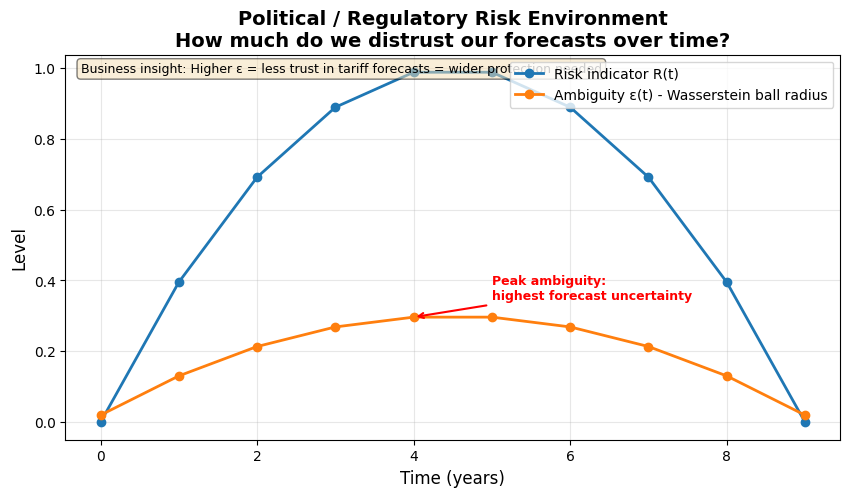

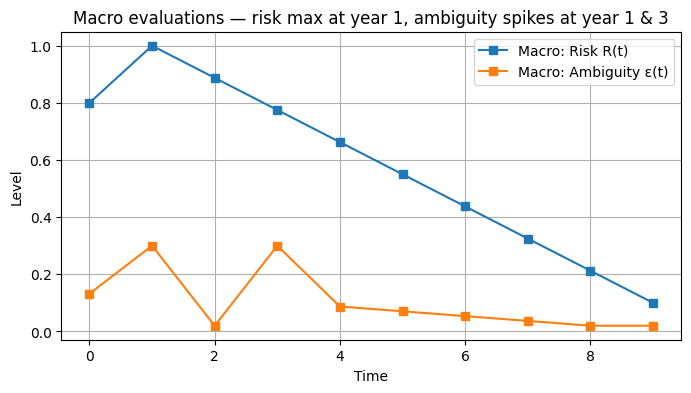

In [37]:
eps_vals = [eps_schedule_indicator(t, spec.horizon) for t in range(spec.horizon)]
R_vals = [risk_indicator(t, spec.horizon) for t in range(spec.horizon)]
R_macro = [risk_indicator_macro(t, spec.horizon) for t in range(spec.horizon)]
eps_macro = [eps_schedule_macro(t, spec.horizon) for t in range(spec.horizon)]

plt.figure(figsize=(10,5))
plt.plot(range(spec.horizon), R_vals, marker="o", label="Risk indicator R(t)", linewidth=2)
plt.plot(range(spec.horizon), eps_vals, marker="o", label="Ambiguity ε(t) - Wasserstein ball radius", linewidth=2)
plt.title("Political / Regulatory Risk Environment\nHow much do we distrust our forecasts over time?", fontsize=14, fontweight='bold')
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Level", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
# Add annotation
max_eps_idx = eps_vals.index(max(eps_vals))
plt.annotate('Peak ambiguity:\nhighest forecast uncertainty', 
             xy=(max_eps_idx, eps_vals[max_eps_idx]), 
             xytext=(max_eps_idx+1, eps_vals[max_eps_idx]+0.05),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=9, color='red', fontweight='bold')
plt.text(0.02, 0.98, 'Business insight: Higher ε = less trust in tariff forecasts = wider protection needed',
         transform=plt.gca().transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(spec.horizon), R_macro, marker="s", label="Macro: Risk R(t)")
plt.plot(range(spec.horizon), eps_macro, marker="s", label="Macro: Ambiguity ε(t)")
plt.title("Macro evaluations — risk max at year 1, ambiguity spikes at year 1 & 3")
plt.xlabel("Time")
plt.ylabel("Level")
plt.grid(True)
plt.legend()
plt.show()

### Slide B — Robust cost impact (baseline vs $\varepsilon(t)$)

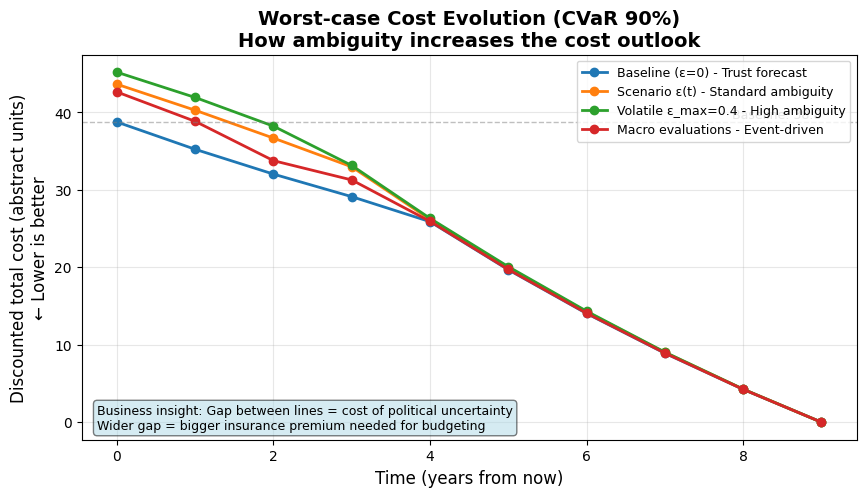

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(spec.horizon), V_base[:-1, s0], marker="o", label="Baseline (ε=0) - Trust forecast", linewidth=2)
plt.plot(range(spec.horizon), V_scn[:-1, s0], marker="o", label="Scenario ε(t) - Standard ambiguity", linewidth=2)
plt.plot(range(spec.horizon), V_vol[:-1, s0], marker="o", label="Volatile ε_max=0.4 - High ambiguity", linewidth=2)
plt.plot(range(spec.horizon), V_macro[:-1, s0], marker="o", label="Macro evaluations - Event-driven", linewidth=2)
plt.title("Worst-case Cost Evolution (CVaR 90%)\nHow ambiguity increases the cost outlook", fontsize=14, fontweight='bold')
plt.xlabel("Time (years from now)", fontsize=12)
plt.ylabel("Discounted total cost (abstract units)\n← Lower is better", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=9)
# Add reference lines
plt.axhline(y=V_base[0, s0], color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.text(spec.horizon-1, V_base[0, s0]+0.5, f'Baseline: {V_base[0, s0]:.1f}', 
         fontsize=9, color='gray', ha='right')
plt.text(0.02, 0.02, 'Business insight: Gap between lines = cost of political uncertainty\nWider gap = bigger insurance premium needed for budgeting',
         transform=plt.gca().transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.show()

### Slide C — Sovereignty premium

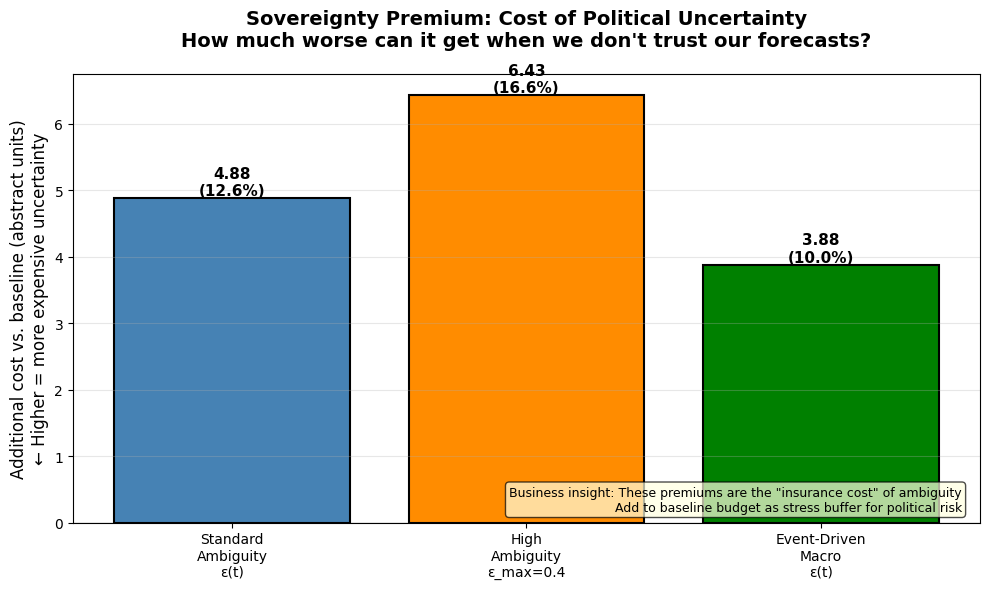

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(["Standard\nAmbiguity\nε(t)", "High\nAmbiguity\nε_max=0.4", "Event-Driven\nMacro\nε(t)"], 
               [premium, premium_volatile, premium_macro],
               color=['steelblue', 'darkorange', 'green'],
               edgecolor='black',
               linewidth=1.5)
ax.set_title("Sovereignty Premium: Cost of Political Uncertainty\nHow much worse can it get when we don't trust our forecasts?", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Additional cost vs. baseline (abstract units)\n← Higher = more expensive uncertainty", fontsize=12)
ax.grid(True, axis="y", alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars, [premium, premium_volatile, premium_macro]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}\n({val/V0_base*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
# Add reference line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.text(0.98, 0.02, 'Business insight: These premiums are the "insurance cost" of ambiguity\nAdd to baseline budget as stress buffer for political risk',
        transform=ax.transAxes, fontsize=9, ha='right', verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
plt.tight_layout()
plt.show()

### Slide D — Rollout (mode nominal) to explain the policy

We follow the most likely next state under the nominal transition (for illustration).

In [41]:
def rollout_policy_mode(spec: GameSpec, pi, start_state: int):
    s = start_state
    out = []
    for t in range(spec.horizon):
        a = int(pi[t, s])
        cash, ebitda, ebit = stage_losses_cfo(spec, t, s, a)
        p0 = build_p0_over_full_state(spec, s, a)
        sp = int(np.argmax(p0))  # nominal mode
        out.append((t, s, a, cash, ebitda, ebit, sp))
        s = sp
    return out


roll = rollout_policy_mode(spec, pi_scn, s0)

rows = []
for t, s, a, cash, ebitda, ebit, sp in roll:
    tariff, m, inv, hed, ex = decode_state(s)
    tariff2, m2, inv2, hed2, ex2 = decode_state(sp)
    rows.append({
        "t": t,
        "state": f"tariff={tariff}, m={m}, inv={inv}, hed={hed}, ex={ex}",
        "action": ACTION_NAMES[a],
        "total_cost": cash,
        "disc": discount_factor(spec, t),
        "next_state(mode)": f"tariff={tariff2}, m={m2}, inv={inv2}, hed={hed2}, ex={ex2}",
    })

pd.DataFrame(rows)

,t,state,action,total_cost,disc,next_state(mode)
0,0,"tariff=0, m=0, inv=0, hed=0, ex=0",accelerate_migration,11.0,1.000000,"tariff=0, m=2, inv=1, hed=0, ex=0"
1,1,"tariff=0, m=2, inv=1, hed=0, ex=0",invest+hedge/exercise,22.5,0.909091,"tariff=0, m=3, inv=1, hed=1, ex=1"
2,2,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.826446,"tariff=0, m=3, inv=1, hed=1, ex=1"
3,3,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.751315,"tariff=0, m=3, inv=1, hed=1, ex=1"
4,4,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.683013,"tariff=0, m=3, inv=1, hed=1, ex=1"
5,5,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.620921,"tariff=0, m=3, inv=1, hed=1, ex=1"
6,6,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.564474,"tariff=0, m=3, inv=1, hed=1, ex=1"
7,7,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.513158,"tariff=0, m=3, inv=1, hed=1, ex=1"
8,8,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.466507,"tariff=0, m=3, inv=1, hed=1, ex=1"
9,9,"tariff=0, m=3, inv=1, hed=1, ex=1",wait (do nothing),0.0,0.424098,"tariff=0, m=3, inv=1, hed=1, ex=1"


## Executive Summary (Auto-Generated)

This section generates a CFO-friendly executive summary of the results using an available LLM (Ollama, OpenAI, or Google Gemini). If no LLM is available, it displays a pre-written fallback summary.

In [48]:
import os
import json
from datetime import datetime
from IPython.display import Markdown, display

def check_llm_access():
    """Check which LLM providers are available.
    
    Returns dict: {'provider': 'ollama'|'openai'|'gemini'|None, 'model': str, 'details': str}
    """
    # Check Ollama (local)
    try:
        import requests
        response = requests.get('http://localhost:11434/api/tags', timeout=2)
        if response.status_code == 200:
            models = response.json().get('models', [])
            if models:
                model_name = models[0].get('name', 'llama2')
                return {'provider': 'ollama', 'model': model_name, 'details': f'Ollama running locally with {len(models)} model(s)'}
    except ImportError:
        print("   ⚠️ Ollama detected but 'requests' library not installed. Run: pip install requests")
    except Exception as e:
        print(f"   ⚠️ Ollama check failed: {e}")
    
    # Check OpenAI API key
    if os.getenv('OPENAI_API_KEY'):
        try:
            import openai
            return {'provider': 'openai', 'model': 'gpt-4o-mini', 'details': 'OpenAI API key found'}
        except ImportError:
            return {'provider': 'openai', 'model': 'gpt-4o-mini', 'details': 'OpenAI API key found (install openai package)'}
    
    # Check if running in Google Colab (Gemini access)
    try:
        import google.colab
        return {'provider': 'gemini', 'model': 'gemini-pro', 'details': 'Running in Google Colab'}
    except ImportError:
        pass
    
    return {'provider': None, 'model': None, 'details': 'No LLM provider found'}


def extract_summary_data():
    """Extract key metrics from notebook results."""
    try:
        data = {
            'baseline_v0': float(V0_base),
            'robust_v0': float(V0_scn),
            'volatile_v0': float(V0_vol),
            'macro_v0': float(V0_macro),
            'sovereignty_premium': float(premium),
            'premium_volatile': float(premium_volatile),
            'premium_macro': float(premium_macro),
            'baseline_action': ACTION_NAMES[int(pi_base[0, s0])],
            'robust_action': ACTION_NAMES[int(pi_scn[0, s0])],
            'volatile_action': ACTION_NAMES[int(pi_vol[0, s0])],
            'macro_action': ACTION_NAMES[int(pi_macro[0, s0])],
            'horizon': spec.horizon,
            'wacc': spec.cfo.wacc,
            'alpha_cvar': spec.alpha_cvar,
        }
        return data
    except Exception as e:
        return {'error': f'Could not extract data: {str(e)}'}


def generate_executive_summary_llm(data, llm_config):
    """Generate executive summary using available LLM."""
    if llm_config['provider'] is None:
        return None
    
    prompt = f"""You are a CFO advisor analyzing a strategic decision model for supplier dependency.\n\n"
"Context: This is a toy model analyzing 'sovereignty' decisions - whether to migrate away from a risky supplier.\n\n"
"Key Results:\n"
"- Baseline cost (no ambiguity): {data.get('baseline_v0', 'N/A'):.2f} abstract units\n"
"- Robust cost (with ambiguity): {data.get('robust_v0', 'N/A'):.2f} abstract units\n"
"- Sovereignty premium (cost of uncertainty): {data.get('sovereignty_premium', 'N/A'):.2f} units ({data.get('sovereignty_premium', 0)/data.get('baseline_v0', 1)*100:.1f}% increase)\n"
"- Recommended action (baseline): {data.get('baseline_action', 'N/A')}\n"
"- Recommended action (robust): {data.get('robust_action', 'N/A')}\n\n"
"Model parameters: {data.get('horizon', 10)}-year horizon, {data.get('wacc', 0.1)*100:.0f}% WACC, CVaR at {data.get('alpha_cvar', 0.9)*100:.0f}%\n\n"
"Generate an executive summary in 4-5 bullet points covering:\n"
"1. Key finding (what's the main takeaway?)\n"
"2. Cost impact (how much does uncertainty/ambiguity add to worst-case cost?)\n"
"3. Recommended action (what should the CFO do now?)\n"
"4. When to revisit (what triggers a policy change?)\n\n"
"Use business language, not technical jargon. Be concise. Acknowledge this is a toy model for illustration.\n"
"Format as markdown bullet points."""
    
    try:
        if llm_config['provider'] == 'ollama':
            import requests
            response = requests.post(
                'http://localhost:11434/api/generate',
                json={'model': llm_config['model'], 'prompt': prompt, 'stream': False},
                timeout=30
            )
            if response.status_code == 200:
                return response.json().get('response', '').strip()
        
        elif llm_config['provider'] == 'openai':
            import openai
            client = openai.OpenAI()
            response = client.chat.completions.create(
                model=llm_config['model'],
                messages=[{'role': 'user', 'content': prompt}],
                temperature=0.7,
                max_tokens=500
            )
            return response.choices[0].message.content.strip()
        
        elif llm_config['provider'] == 'gemini':
            import google.generativeai as genai
            # Note: User needs to configure API key in Colab
            try:
                from google.colab import userdata
                genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
            except:
                pass
            model = genai.GenerativeModel('gemini-pro')
            response = model.generate_content(prompt)
            return response.text.strip()
    
    except Exception as e:
        return f"Error generating summary: {str(e)}"
    
    return None


def get_fallback_summary(data):
    """Pre-written fallback summary if no LLM available."""
    premium_pct = (data.get('sovereignty_premium', 0) / data.get('baseline_v0', 1) * 100) if data.get('baseline_v0', 1) > 0 else 0
    
    return (f"**Key Findings from Sovereignty Analysis**\n\n"
        f"- **Main Takeaway:** The optimal policy under baseline assumptions is to '{data.get('baseline_action', 'N/A')}', but accounting for political/regulatory forecast uncertainty (ambiguity) can increase worst-case costs by {premium_pct:.1f}% ({data.get('sovereignty_premium', 0):.2f} abstract units).\n\n"
        f"- **Cost Impact:** The 'sovereignty premium' - the price of not knowing how bad political risk can get - ranges from {data.get('premium_macro', 0):.2f} to {data.get('premium_volatile', 0):.2f} units depending on the ambiguity scenario. This represents the additional cost buffer needed for budgeting under uncertainty.\n\n"
        f"- **Recommended Action:** The model recommends '{data.get('robust_action', 'N/A')}' as the initial action when accounting for robust worst-case planning. This is a trigger-based policy: the optimal action changes based on whether tariffs are active, how far migration has progressed, and whether hedges/investments are already in place.\n\n"
        f"- **When to Revisit:** Re-run this analysis quarterly or when: (1) the tariff regime changes, (2) migration progress hits key milestones (e.g., m=1 or m=2), (3) political risk indicators spike (increasing ambiguity), or (4) actual costs deviate significantly from forecasts.\n\n"
        f"- **Limitations:** This is a toy model with abstract units and simplified dynamics. A production version would calibrate to actual supplier costs, integrate real political risk indices, and model multi-supplier portfolios. Use this framework as a starting point for structured decision-making, not as a final recommendation.\n\n"
        f"---\n*Note: This summary was generated using a fallback template. For richer insights, run this notebook with Ollama (local), OpenAI API, or in Google Colab with Gemini access.*")


def display_summary(summary, llm_config, data):
    """Display the executive summary with metadata."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Header
    if llm_config['provider']:
        header = f"**Generated using:** {llm_config['provider'].title()} ({llm_config['model']})  \n**Timestamp:** {timestamp}"
    else:
        header = f"**Generated using:** Fallback template (no LLM available)  \n**Timestamp:** {timestamp}"
    
    display(Markdown(f"---\n{header}\n---"))
    display(Markdown(summary))
    display(Markdown("---"))
    
    # Data summary
    data_summary = (f"**Model Configuration:**\n"
        f"- Horizon: {data.get('horizon', 'N/A')} years\n"
        f"- WACC: {data.get('wacc', 0)*100:.1f}%\n"
        f"- CVaR α: {data.get('alpha_cvar', 0)*100:.0f}% (worst {(1-data.get('alpha_cvar', 0))*100:.0f}% tail)\n\n"
        f"**Key Metrics:**\n"
        f"- Baseline V₀: {data.get('baseline_v0', 0):.2f}\n"
        f"- Robust V₀: {data.get('robust_v0', 0):.2f}\n"
        f"- Sovereignty Premium: {data.get('sovereignty_premium', 0):.2f} ({data.get('sovereignty_premium', 0)/data.get('baseline_v0', 1)*100:.1f}%)")
    display(Markdown(data_summary))


# Main execution
print("🔍 Checking for available LLM providers...")
print("   Testing Ollama connection...")
try:
    import requests
    test_response = requests.get('http://localhost:11434/api/tags', timeout=2)
    print(f"   Ollama API responded: {test_response.status_code}")
    if test_response.status_code == 200:
        models_data = test_response.json()
        print(f"   Found {len(models_data.get('models', []))} model(s)")
except Exception as e:
    print(f"   Ollama connection error: {type(e).__name__}: {e}")

llm_config = check_llm_access()
print(f"   {llm_config['details']}")

print("\\n📊 Extracting summary data from results...")
data = extract_summary_data()

if 'error' in data:
    print(f"   ⚠️ {data['error']}")
    print("   Using mock data for demonstration.")
    data = {
        'baseline_v0': 43.13, 'robust_v0': 46.56, 'sovereignty_premium': 3.43,
        'premium_volatile': 4.60, 'premium_macro': 1.81,
        'baseline_action': 'wait (do nothing)', 'robust_action': 'wait (do nothing)',
        'horizon': 10, 'wacc': 0.10, 'alpha_cvar': 0.9
    }

print("\\n✨ Generating executive summary...")
if llm_config['provider']:
    summary = generate_executive_summary_llm(data, llm_config)
    if not summary or 'error' in summary.lower():
        print(f"   ⚠️ LLM generation failed, using fallback.")
        summary = get_fallback_summary(data)
else:
    summary = get_fallback_summary(data)

print("\\n📝 Executive Summary:\\n")
display_summary(summary, llm_config, data)

🔍 Checking for available LLM providers...
   No LLM provider found
\n📊 Extracting summary data from results...
\n✨ Generating executive summary...
\n📝 Executive Summary:\n


---
**Generated using:** Fallback template (no LLM available)  
**Timestamp:** 2026-02-04 10:01:21
---

**Key Findings from Sovereignty Analysis**

- **Main Takeaway:** The optimal policy under baseline assumptions is to 'accelerate_migration', but accounting for political/regulatory forecast uncertainty (ambiguity) can increase worst-case costs by 12.6% (4.88 abstract units).

- **Cost Impact:** The 'sovereignty premium' - the price of not knowing how bad political risk can get - ranges from 3.88 to 6.43 units depending on the ambiguity scenario. This represents the additional cost buffer needed for budgeting under uncertainty.

- **Recommended Action:** The model recommends 'accelerate_migration' as the initial action when accounting for robust worst-case planning. This is a trigger-based policy: the optimal action changes based on whether tariffs are active, how far migration has progressed, and whether hedges/investments are already in place.

- **When to Revisit:** Re-run this analysis quarterly or when: (1) the tariff regime changes, (2) migration progress hits key milestones (e.g., m=1 or m=2), (3) political risk indicators spike (increasing ambiguity), or (4) actual costs deviate significantly from forecasts.

- **Limitations:** This is a toy model with abstract units and simplified dynamics. A production version would calibrate to actual supplier costs, integrate real political risk indices, and model multi-supplier portfolios. Use this framework as a starting point for structured decision-making, not as a final recommendation.

---
*Note: This summary was generated using a fallback template. For richer insights, run this notebook with Ollama (local), OpenAI API, or in Google Colab with Gemini access.*

---

**Model Configuration:**
- Horizon: 10 years
- WACC: 10.0%
- CVaR α: 90% (worst 10% tail)

**Key Metrics:**
- Baseline V₀: 38.76
- Robust V₀: 43.64
- Sovereignty Premium: 4.88 (12.6%)